# Chapter 7



In [2]:
# Listing 7.1: Calculate the prior‐probability
import pandas as pd
train = pd.read_csv('./data/train.csv')

# total
cnt_all = len(train)

# list of all survivors
survivors =  train[train.Survived.eq(1)]
cnt_survivors = len(survivors)

# calculate the prior probability
prob_survival = len(survivors)/cnt_all

print("The prior probability to survive is: ", round(prob_survival, 2))

The prior probability to survive is:  0.38


## Section 7.1: Pre-processing

In [3]:
# Listing 7.2: Calculating the ticket class modifier
# get the modifier given the passenger's pclass
def get_modifier_pclass(pclass):
    # number of passengers with the same pclass
    cnt_surv_pclass = len(survivors[survivors.Pclass.eq(pclass)])

    # backward probability
    p_cl_surv = cnt_surv_pclass/cnt_survivors
    
    # probability of the evidence
    p_cl = len(train[train.Pclass.eq(pclass)])/cnt_all

    return p_cl_surv/p_cl

In [4]:
# Listing 7.3: Calculating the gender modifier
# get the modifier given the passenger's pclass
def get_modifier_sex(sex):
    # number of passengers with the same pclass
    cnt_surv_sex = len(survivors[survivors.Sex.eq(sex)])

    # backward probability
    p_sex_surv = cnt_surv_sex/cnt_survivors
    
    # probability of the evidence
    p_sex = len(train[train.Sex.eq(sex)])/cnt_all

    return p_sex_surv/p_sex

In [5]:
# Listing 7.4: Pre‐processing
def pre_process(passenger):
    """
    passenger -- the Pandas dataframe-row of the passenger
    returns a list of modifiers, like this [modifier_a, modifier_b, ...]
    """
    return [
        get_modifier_pclass(passenger["Pclass"]),
        get_modifier_sex(passenger["Sex"]),
    ]

In [6]:
# Listing 7.5: Two exemplary passengers
# a female passenger with 1st class ticket
print (pre_process(train.iloc[52]))

# a male passenger with 3rd class ticket
print (pre_process(train.iloc[26]))

[1.6403508771929822, 1.9332048273550118]
[0.6314181584306999, 0.49215543190732464]


In [14]:
# Listing 7.6 to 7.13 and 7.16 to 7.17
from functools import reduce
from qiskit import QuantumCircuit, Aer, execute, ClassicalRegister, QuantumRegister
from math import asin, sqrt, ceil
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def prob_to_angle(prob):
    """
    Converts a given P(psi) value into an equivalent theta value.
    """
    return 2*asin(sqrt(prob))
def pqc(backend, prior, modifiers, shots=1, hist=False, measure=False):
    # Prepare the circuit with qubits and a classical bit to hold the measurement
    qr = QuantumRegister(7)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

    # the qubit positions
    trunks = 3
    aux = trunks+1
    aux_half = trunks+1
    aux_full = trunks+2
    target = trunks+3

    # Apply prior to qubit to the target qubit
    qc.ry(prob_to_angle(prior), target)

    # Work with the remainder
    qc.x(target)

    # Apply prior to full auxiliary qubit
    qc.cry(prob_to_angle(prior/(1-prior)), target, aux_full)

    # Work with the remainder
    qc.cx(aux_full,target)

    # Apply 0.5*prior to qubit 1
    qc.cry(prob_to_angle(0.5*prior/(1-(2*prior))), target,aux_half)

    # Rearrange states to separated qubits
    qc.x(target)
    qc.cx(aux_full, target)
    
    sorted_modifiers = sorted(modifiers)

    for step in range(0, len(modifiers)):
        if sorted_modifiers[step] > 1:
            qc.cry(prob_to_angle(min(1, sorted_modifiers[step]-1)), aux_full, target)

            # separate the aux_full and the target qubit
            qc.ccx(target, aux_full, 0)
            qc.ccx(target, 0, aux_full)
            
            if step == 0:
                # equalize what we transferred to the target (*2) and increase the aux_full to reflect the modifier (*2)
                qc.cry(prob_to_angle(min(1,(sorted_modifiers[step]-1)*2*2)), aux_half, aux_full)

        else: 
            # apply modifier to the target qubit
            qc.cry(prob_to_angle(1-sorted_modifiers[step]), target, step*2)
            qc.cx(step*2,target)

            if step == 0:
                # apply modifier to full auxiliary qubit
                qc.cry(prob_to_angle(1-sorted_modifiers[step]), aux_full, step*2+1)

                # unentangle the full auxiliary from trunk
                qc.cx(step*2+1,aux_full)

            
    # measure the qubit only if we want the measurement to be included
    if measure:
        qc.measure(qr[target], cr[0])
    results = execute(qc,backend, shots=shots).result().get_counts()
    return plot_histogram(results, figsize=(12,4)) if hist else results

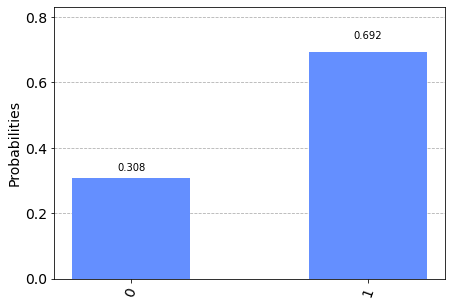

In [15]:
# Listing 7.14: Include the measurement into the circuit
plot_histogram(pqc(Aer.get_backend('qasm_simulator') , 0.38, [1.4, 1.3], shots=1000, hist=False, measure=True))

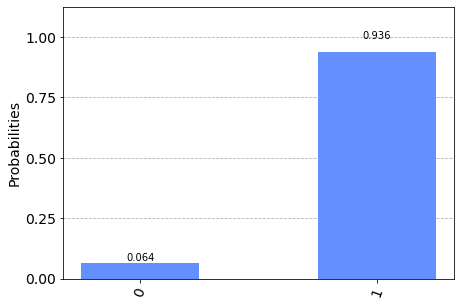

In [16]:
# Listing 7.15: Calculate the posterior of a female passenger with a first‐class‐ticket
plot_histogram(pqc(Aer.get_backend('qasm_simulator') , 0.38, [1.6403508771929822, 1.9332048273550118], shots=1000, hist=False, measure=True))

In [17]:
# Listing 7.18: Post‐processing
def post_process(counts):
    """
    counts -- the result of the quantum circuit execution
    returns the prediction
    """
    return int(list(map(lambda item: item[0], counts.items()))[0])

In [25]:
# REDEFINE OR IMPORT THE FUNCTIONS OF CHAPTER 2
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def run(f_classify, x):
    return list(map(f_classify, x))

def specificity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1]) if (matrix[0][0]+matrix[0][1] > 0) else 0

def npv(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0]) if (matrix[0][0]+matrix[1][0] > 0) else 0

def classifier_report(name, run, classify, input, labels):
    cr_predictions = run(classify, input)
    cr_cm = confusion_matrix(labels, cr_predictions)

    cr_precision = precision_score(labels, cr_predictions)
    cr_recall = recall_score(labels, cr_predictions)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)

    print('The precision score of the {} classifier is {:.2f}'
        .format(name, cr_precision))
    print('The recall score of the {} classifier is {:.2f}'
        .format(name, cr_recall))
    print('The specificity score of the {} classifier is {:.2f}'
        .format(name, cr_specificity))
    print('The npv score of the {} classifier is {:.2f}'
        .format(name, cr_npv))
    print('The information level is: {:.2f}'
        .format(cr_level))
#CAPTION A reusable function to unmask the hypocrite classifier

In [26]:
# Listing 7.19: Run the Quantum Naive Bayes Classifier
# redefine the run-function
def run(f_classify, data):
    return [f_classify(data.iloc[i]) for i in range(0,len(data))]

# specify a reusable backend
backend = Aer.get_backend('qasm_simulator') 

# evaluate the Quantum Naive Bayes classifier
classifier_report("QuantumNaiveBayes",
    run,
    lambda passenger: post_process(pqc(backend, prob_survival, pre_process(passenger), measure=True, hist=False)),
    train,
    train['Survived'])

The precision score of the QuantumNaiveBayes classifier is 0.66
The recall score of the QuantumNaiveBayes classifier is 0.62
The specificity score of the QuantumNaiveBayes classifier is 0.80
The npv score of the QuantumNaiveBayes classifier is 0.77
The information level is: 0.71
